<a href="https://colab.research.google.com/github/AriaRahman/CVPR/blob/main/assignment_2_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(0)

In [30]:
# Generate a synthetic dataset with 5 classes


num_samples = 3500
num_features = 10

#X is 3500 samples with 10 features.
X = np.random.randn(num_samples, num_features)
#Y is based on which pair of features has the largest sum
Y = np.argmax(np.vstack([
    X[:, 0:2].sum(axis=1),
    X[:, 2:4].sum(axis=1),
    X[:, 4:6].sum(axis=1),
    X[:, 6:8].sum(axis=1),
    X[:, 8:10].sum(axis=1)
]).T, axis=1)

print("Dataset created!")
print("X:", X.shape)
print("Y:", Y.shape)
print("classes in Y:", np.unique(Y))


Dataset created!
X: (3500, 10)
Y: (3500,)
classes in Y: [0 1 2 3 4]


In [31]:
#split
indices = np.arange(X.shape[0])
np.random.shuffle(indices)

X = X[indices]
Y = Y[indices]

# 75% train, 25% test
split = int(0.75 * X.shape[0])

X_train = X[:split]
Y_train = Y[:split]

X_test = X[split:]
Y_test = Y[split:]

In [32]:
#check for shapes
print("Train X shape:", X_train.shape)
print("Train Y shape:", Y_train.shape)
print("Test X shape:", X_test.shape)
print("Test Y shape:", Y_test.shape)

#checking for distribution of class labels

print("\nClass counts in full dataset:", np.bincount(Y))
print("Class counts in training set:", np.bincount(Y_train))
print("Class counts in test set:", np.bincount(Y_test))


Train X shape: (2625, 10)
Train Y shape: (2625,)
Test X shape: (875, 10)
Test Y shape: (875,)

Class counts in full dataset: [671 689 681 717 742]
Class counts in training set: [484 529 504 548 560]
Class counts in test set: [187 160 177 169 182]


In [33]:
# Neural Network class
class NeuralNetwork(object):
    def __init__(self):
        inputLayerNeurons = 10 #num of neurons
        hiddenLayer1 = 64
        hiddenLayer2 = 32
        hiddenLayer3 = 16
        outputNeurons = 5  # num of classes

        self.learning_rate = 0.01

        # Weight initialization
        self.W_H1 = np.random.randn(inputLayerNeurons, hiddenLayer1)
        self.W_H2 = np.random.randn(hiddenLayer1, hiddenLayer2)
        self.W_H3 = np.random.randn(hiddenLayer2, hiddenLayer3)
        self.W_O  = np.random.randn(hiddenLayer3, outputNeurons)

    # Sigmoid activation - hidden layers
    def sigmoid(self, x, der=False):
        s = 1 / (1 + np.exp(-x))
        if der:
            return s * (1 - s)
        return s

    # Softmax activation - output layer
    def softmax(self, x):
        e = np.exp(x - np.max(x, axis=1, keepdims=True))
        return e / np.sum(e, axis=1, keepdims=True)

    # Feedforward
    def feedForward(self, X):
        self.Z1 = np.dot(X, self.W_H1)
        self.A1 = self.sigmoid(self.Z1)

        self.Z2 = np.dot(self.A1, self.W_H2)
        self.A2 = self.sigmoid(self.Z2)

        self.Z3 = np.dot(self.A2, self.W_H3)
        self.A3 = self.sigmoid(self.Z3)

        self.Z4 = np.dot(self.A3, self.W_O)
        self.pred = self.softmax(self.Z4)

        return self.pred

    # Backpropagation
    def backPropagation(self, X, Y):
        m = X.shape[0]
        pred = self.pred.copy()


        Y_onehot = np.zeros_like(pred)
        Y_onehot[np.arange(m), Y] = 1

        output_error = (pred - Y_onehot) / m
        output_delta = output_error

        hidden3_error = output_delta.dot(self.W_O.T)
        hidden3_delta = hidden3_error * self.sigmoid(self.A3, der=True)

        hidden2_error = hidden3_delta.dot(self.W_H3.T)
        hidden2_delta = hidden2_error * self.sigmoid(self.A2, der=True)

        hidden1_error = hidden2_delta.dot(self.W_H2.T)
        hidden1_delta = hidden1_error * self.sigmoid(self.A1, der=True)

        self.W_O  -= self.learning_rate * self.A3.T.dot(output_delta)
        self.W_H3 -= self.learning_rate * self.A2.T.dot(hidden3_delta)
        self.W_H2 -= self.learning_rate * self.A1.T.dot(hidden2_delta)
        self.W_H1 -= self.learning_rate * X.T.dot(hidden1_delta)

    # Train function
    def train(self, X, Y):
        self.feedForward(X)
        self.backPropagation(X, Y)

    # Predict
    def predict(self, X):
        probs = self.feedForward(X)
        return np.argmax(probs, axis=1)



In [39]:
# Initialize network
NN = NeuralNetwork()

errors = []
train_acc_list = []
precision_list = []
recall_list = []
f1_list = []

epochs = 2000
patience = 50
best_loss = float('inf')
patience_counter = 0

num_classes = 5

for i in range(epochs):
    # Train
    NN.train(X_train, Y_train)

    # Forward pass
    pred_train = NN.feedForward(X_train)

    # Loss
    loss = -np.mean(np.log(pred_train[np.arange(len(Y_train)), Y_train] + 1e-8))
    errors.append(loss)

    # Predictions
    y_pred = np.argmax(pred_train, axis=1)
    y_true = Y_train

    # Accuracy
    acc = np.mean(y_pred == y_true)
    train_acc_list.append(acc)

    # Precision, Recall, F1 per class
    precision_epoch = []
    recall_epoch = []
    f1_epoch = []

    print(f"\nEpoch {i}:")
    print(f" Overall Accuracy: {acc:.4f}")

    for c in range(num_classes):
        TP = np.sum((y_pred == c) & (y_true == c))
        FP = np.sum((y_pred == c) & (y_true != c))
        FN = np.sum((y_pred != c) & (y_true == c))

        prec = TP / (TP + FP + 1e-8)
        rec  = TP / (TP + FN + 1e-8)
        f1_c = 2 * prec * rec / (prec + rec + 1e-8)

        precision_epoch.append(prec)
        recall_epoch.append(rec)
        f1_epoch.append(f1_c)

        print(f" Class {c}: Precision={prec:.4f}, Recall={rec:.4f}, F1-Score={f1_c:.4f}")

    # Weighted/Average metrics
    weights = np.array([np.sum(y_true == c) for c in range(num_classes)]) / len(y_true)
    precision_list.append(np.sum(np.array(precision_epoch) * weights))
    recall_list.append(np.sum(np.array(recall_epoch) * weights))
    f1_list.append(np.sum(np.array(f1_epoch) * weights))

    print(f" Weighted Precision: {precision_list[-1]:.4f}, Weighted Recall: {recall_list[-1]:.4f}, Weighted F1: {f1_list[-1]:.4f}")

    # Early stopping
    if loss < best_loss - 1e-6:
        best_loss = loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"\nEarly stopping at epoch {i}, Loss: {loss:.4f}")
        break

    if i % 100 == 0:
        print(f"Epoch {i} Summary -> Loss: {loss:.4f}, Accuracy: {acc:.4f}")


Streaming output truncated to the last 5000 lines.

Epoch 1445:
 Overall Accuracy: 0.7470
 Class 0: Precision=0.7332, Recall=0.6983, F1-Score=0.7153
 Class 1: Precision=0.7924, Recall=0.7070, F1-Score=0.7473
 Class 2: Precision=0.6962, Recall=0.8095, F1-Score=0.7486
 Class 3: Precision=0.7780, Recall=0.6971, F1-Score=0.7353
 Class 4: Precision=0.7463, Recall=0.8196, F1-Score=0.7813
 Weighted Precision: 0.7502, Weighted Recall: 0.7470, Weighted F1: 0.7464

Epoch 1446:
 Overall Accuracy: 0.7474
 Class 0: Precision=0.7332, Recall=0.6983, F1-Score=0.7153
 Class 1: Precision=0.7924, Recall=0.7070, F1-Score=0.7473
 Class 2: Precision=0.6968, Recall=0.8115, F1-Score=0.7498
 Class 3: Precision=0.7796, Recall=0.6971, F1-Score=0.7360
 Class 4: Precision=0.7463, Recall=0.8196, F1-Score=0.7813
 Weighted Precision: 0.7506, Weighted Recall: 0.7474, Weighted F1: 0.7468

Epoch 1447:
 Overall Accuracy: 0.7470
 Class 0: Precision=0.7332, Recall=0.6983, F1-Score=0.7153
 Class 1: Precision=0.7919, Recall=

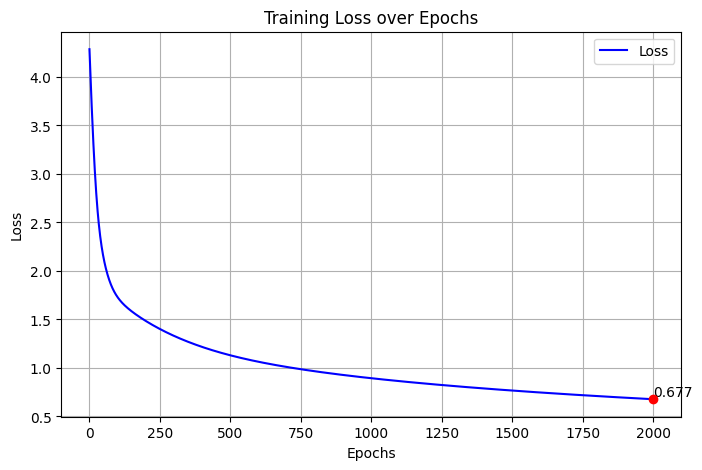

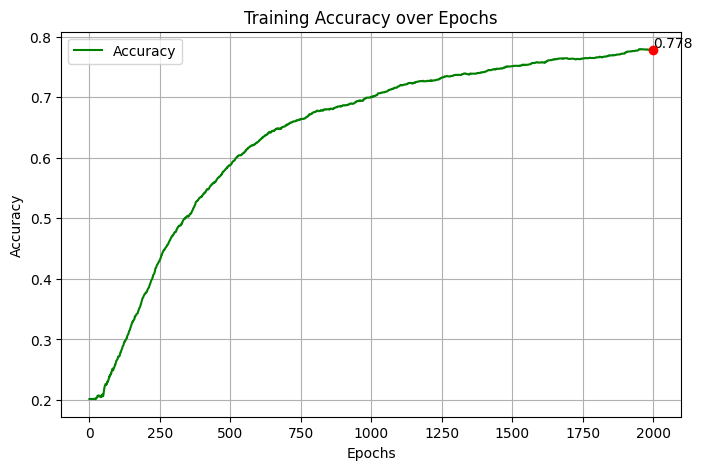

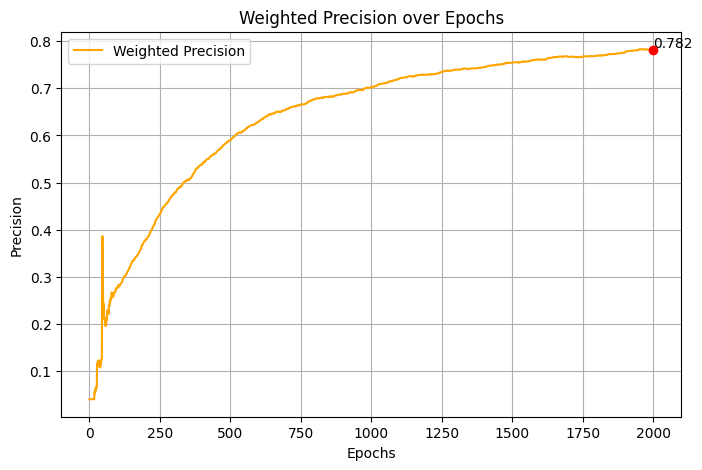

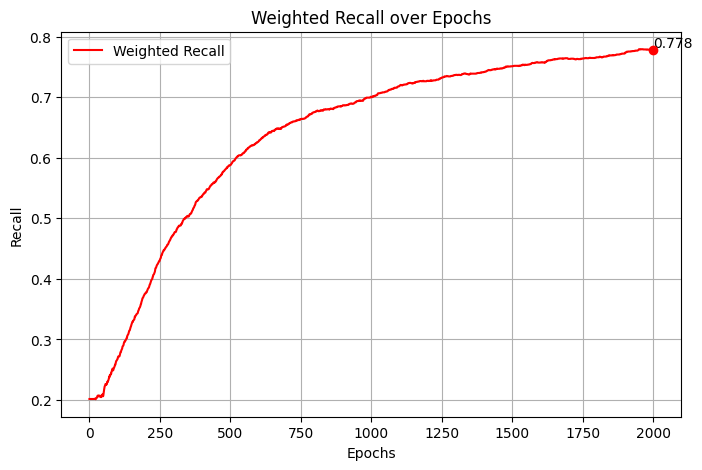

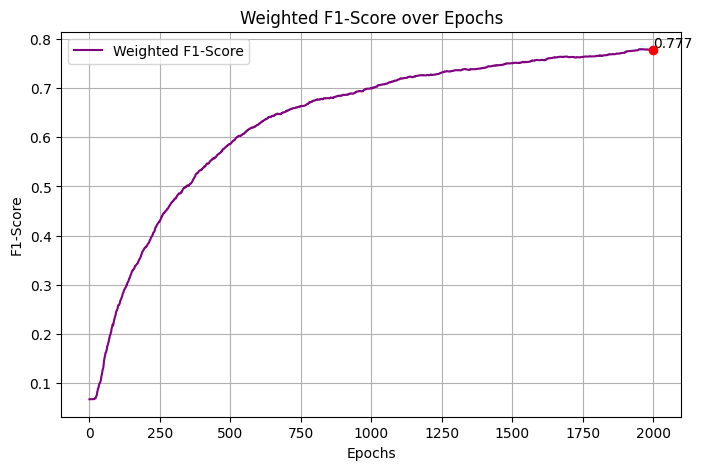

In [46]:
# Training Loss
plt.figure(figsize=(8,5))
plt.plot(errors, label="Loss", color="blue")
plt.scatter(len(errors)-1, errors[-1], color="red", zorder=5)
plt.text(len(errors)-1, errors[-1], f"{errors[-1]:.3f}", fontsize=10, ha='left', va='bottom')
plt.title("Training Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

# Plot Training Accuracy
plt.figure(figsize=(8,5))
plt.plot(train_acc_list, label="Accuracy", color="green")
plt.scatter(len(train_acc_list)-1, train_acc_list[-1], color="red", zorder=5)
plt.text(len(train_acc_list)-1, train_acc_list[-1], f"{train_acc_list[-1]:.3f}", fontsize=10, ha='left', va='bottom')
plt.title("Training Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()

#Precision
plt.figure(figsize=(8,5))
plt.plot(precision_list, label="Weighted Precision", color="orange")
plt.scatter(len(precision_list)-1, precision_list[-1], color="red", zorder=5)
plt.text(len(precision_list)-1, precision_list[-1], f"{precision_list[-1]:.3f}", fontsize=10, ha='left', va='bottom')
plt.title("Weighted Precision over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.grid(True)
plt.legend()
plt.show()

#Recall
plt.figure(figsize=(8,5))
plt.plot(recall_list, label="Weighted Recall", color="red")
plt.scatter(len(recall_list)-1, recall_list[-1], color="red", zorder=5)
plt.text(len(recall_list)-1, recall_list[-1], f"{recall_list[-1]:.3f}", fontsize=10, ha='left', va='bottom')
plt.title("Weighted Recall over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.grid(True)
plt.legend()
plt.show()

#F1-Score
plt.figure(figsize=(8,5))
plt.plot(f1_list, label="Weighted F1-Score", color="purple")
plt.scatter(len(f1_list)-1, f1_list[-1], color="red", zorder=5)
plt.text(len(f1_list)-1, f1_list[-1], f"{f1_list[-1]:.3f}", fontsize=10, ha='left', va='bottom')
plt.title("Weighted F1-Score over Epochs")
plt.xlabel("Epochs")
plt.ylabel("F1-Score")
plt.grid(True)
plt.legend()
plt.show()


Confusion Matrix:
[[126   2  18  22  19]
 [  3 112  18   7  20]
 [  5   4 153   8   7]
 [ 19  14  19 109   8]
 [ 10  11  10   5 146]]


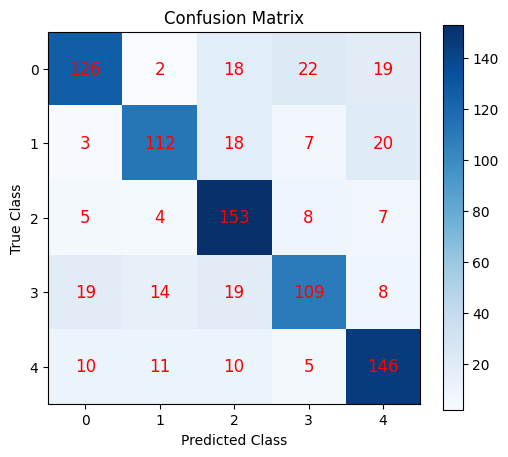

In [48]:
# Confusion Matrix
y_pred = NN.predict(X_test)
y_true = Y_test

conf_matrix = np.zeros((num_classes, num_classes), dtype=int)

for t, p in zip(y_true, y_pred):
    conf_matrix[t, p] += 1

print("Confusion Matrix:")
print(conf_matrix)


plt.figure(figsize=(6,5))
plt.imshow(conf_matrix, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.colorbar()
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, conf_matrix[i,j], ha='center', va='center', color='red', fontsize=12)
plt.show()


